In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer.autoguide.guides import AutoNormal, AutoDelta

from pyro.optim import Adam
from pyro.infer import SVI

/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cellij

In [5]:
pyro.enable_validation(True)

In [6]:
from tqdm import tqdm

In [7]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: <object object at 0x147778d80>


In [8]:
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.0,
    rc={"lines.linewidth": 5},
)

In [9]:
from cellij.core.synthetic import DataGenerator

In [10]:
n_samples = 200
n_features = [400, 400, 400]
dg = DataGenerator(n_samples, n_features)
rng = dg.generate(all_feature_group_combs=True)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
Generating all possible binary combinations of 3 variables.
New factor configuration across `features` groups: 1 fully shared, 3 partially shared, 3 private factors.


<AxesSubplot:>

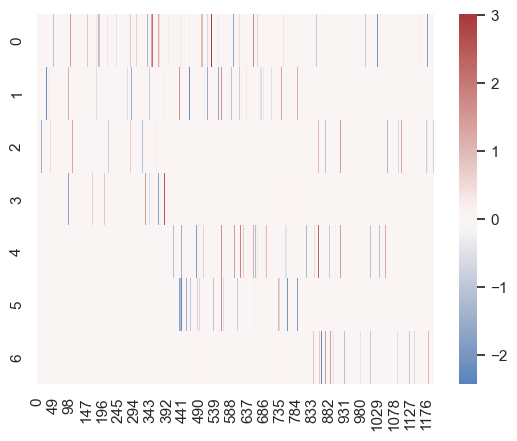

In [11]:
sns.heatmap(dg.w, center=0, cmap="vlag")

In [12]:
model = cellij.core._pyro_models.Generative(
        n_factors=dg.n_factors,
        obs_dict={"group_0": dg.n_samples},
        feature_dict={f"view_{m}": dg.n_features[m] for m in range(dg.n_feature_groups)},
        likelihoods={f"view_{m}": "Normal" for m in range(dg.n_feature_groups)},
        factor_priors={
            "group_0": "Laplace",
        },
        weight_priors={
            "view_0": "Laplace",
            "view_1": "Horseshoe",
            "view_2": "SpikeAndSlab",
        },
        device=torch.device("cpu"),
    )

for k, v in model().items():
    print(k, v.shape)

z_group_0 torch.Size([200, 7, 1])
w_view_0 torch.Size([7, 400])
sigma_view_0 torch.Size([400])
w_view_1 torch.Size([7, 400])
sigma_view_1 torch.Size([400])
w_view_2 torch.Size([7, 400])
sigma_view_2 torch.Size([400])
x_group_0_view_0 torch.Size([200, 400])
x_group_0_view_1 torch.Size([200, 400])
x_group_0_view_2 torch.Size([200, 400])


In [13]:
data = {"group_0": {f"view_{m}": torch.Tensor(dg.ys[m]) for m in range(dg.n_feature_groups)}}
for k, v in model(data).items():
    print(k, v.shape)

z_group_0 torch.Size([200, 7, 1])
w_view_0 torch.Size([7, 400])
sigma_view_0 torch.Size([400])
w_view_1 torch.Size([7, 400])
sigma_view_1 torch.Size([400])
w_view_2 torch.Size([7, 400])
sigma_view_2 torch.Size([400])
x_group_0_view_0 torch.Size([200, 400])
x_group_0_view_1 torch.Size([200, 400])
x_group_0_view_2 torch.Size([200, 400])


In [14]:
{k:v.site_name for k, v in model.factor_priors.items()}

{'group_0': 'z_group_0'}

In [15]:
{k:v.site_name for k, v in model.weight_priors.items()}

{'view_0': 'w_view_0', 'view_1': 'w_view_1', 'view_2': 'w_view_2'}

Cleaning parameter store


100%|██████████| 100/100 [02:36<00:00,  1.57s/it, ELBO=4.76e+7]


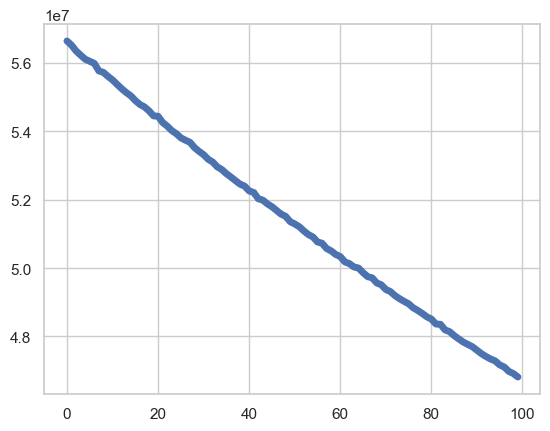

In [16]:
# clean start
print("Cleaning parameter store")
pyro.clear_param_store()

guide = AutoNormal(model)
svi = SVI(model, guide, Adam({"lr": 0.005, "betas": (0.95, 0.999)}), loss=pyro.infer.TraceMeanField_ELBO(num_particles=5))

elbo_history = []
pbar = tqdm(range(100))
for iteration_idx in pbar:
    elbo = svi.step(data)
    elbo_history.append(elbo)
    if iteration_idx % 10 == 0:
        pbar.set_postfix({"ELBO": elbo})

plt.plot(elbo_history)

In [17]:
pyro.get_param_store().get_all_param_names()

dict_keys(['AutoNormal.locs.z_group_0', 'AutoNormal.scales.z_group_0', 'AutoNormal.locs.w_view_0', 'AutoNormal.scales.w_view_0', 'AutoNormal.locs.sigma_view_0', 'AutoNormal.scales.sigma_view_0', 'AutoNormal.locs.w_view_1_tau', 'AutoNormal.scales.w_view_1_tau', 'AutoNormal.locs.w_view_1_lambdas', 'AutoNormal.scales.w_view_1_lambdas', 'AutoNormal.locs.w_view_1', 'AutoNormal.scales.w_view_1', 'AutoNormal.locs.sigma_view_1', 'AutoNormal.scales.sigma_view_1', 'AutoNormal.locs.w_view_2_thetas', 'AutoNormal.scales.w_view_2_thetas', 'AutoNormal.locs.w_view_2_lambdas', 'AutoNormal.scales.w_view_2_lambdas', 'AutoNormal.locs.w_view_2_unconstrained', 'AutoNormal.scales.w_view_2_unconstrained', 'AutoNormal.locs.sigma_view_2', 'AutoNormal.scales.sigma_view_2'])

In [18]:
z_hat = pyro.get_param_store().get_param("AutoNormal.locs.z_group_0").squeeze().detach().numpy()
ws_hat = []
ws_hat.append(pyro.get_param_store().get_param("AutoNormal.locs.w_view_0").squeeze().detach().numpy())
ws_hat.append(pyro.get_param_store().get_param("AutoNormal.locs.w_view_1").squeeze().detach().numpy())
ws_hat.append(pyro.get_param_store().get_param("AutoNormal.locs.w_view_2_unconstrained").squeeze().detach().numpy() * pyro.get_param_store().get_param("AutoNormal.locs.w_view_2_lambdas").squeeze().detach().numpy())

<AxesSubplot:>

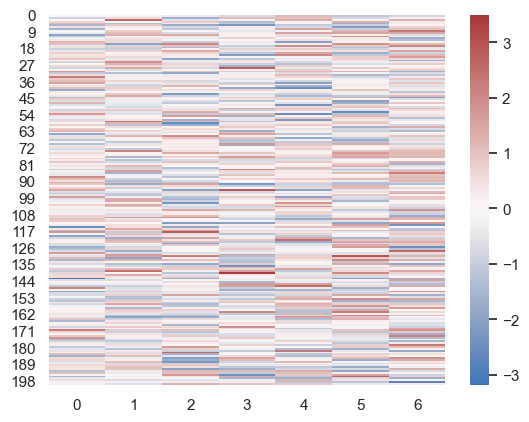

In [19]:
sns.heatmap(dg.z, center=0, cmap="vlag")

<AxesSubplot:>

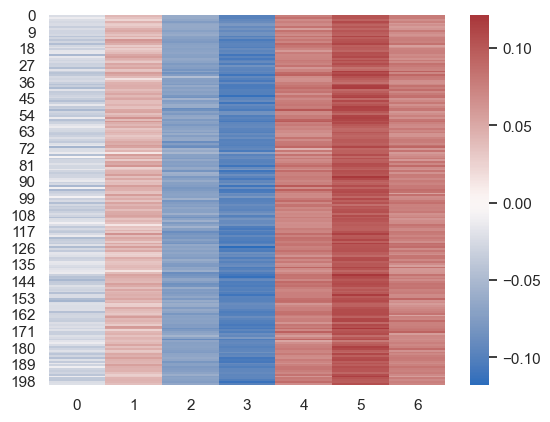

In [20]:
sns.heatmap(z_hat, center=0, cmap="vlag")

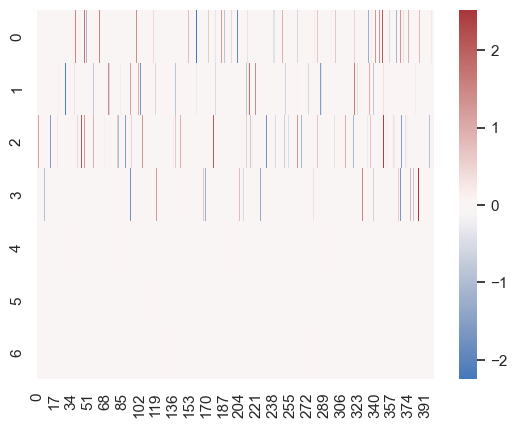

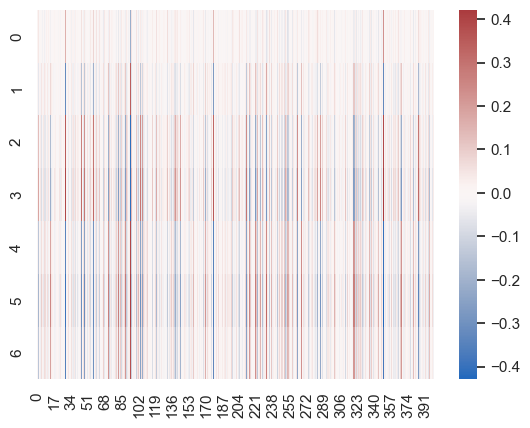

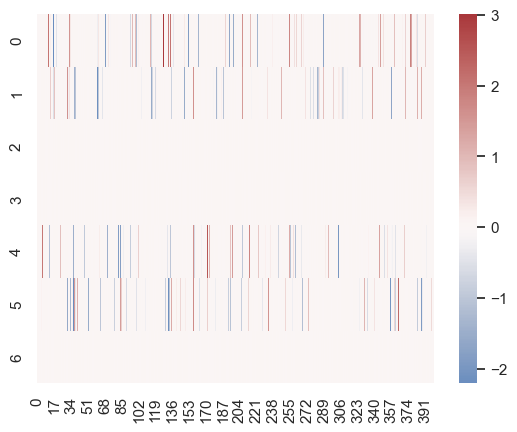

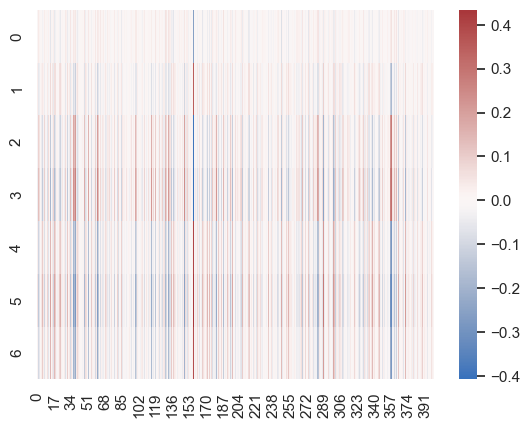

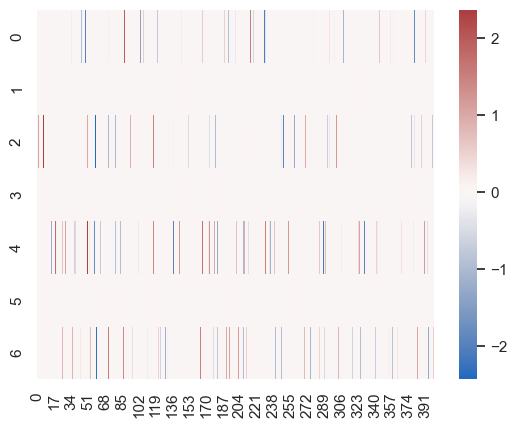

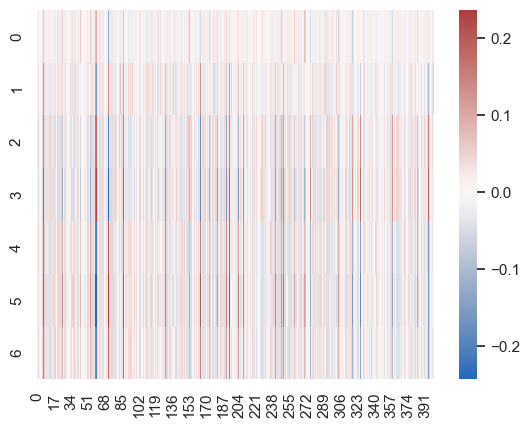

In [21]:
for m in range(dg.n_feature_groups):
    sns.heatmap(dg.ws[m], center=0, cmap="vlag")
    plt.show()
    sns.heatmap(ws_hat[m], center=0, cmap="vlag")
    plt.show()